Выполнил Велесов Даниил группа М8О-114СВ-24

# Bank Transaction Dataset for Fraud Detection

### Этот набор данных дает подробное представление о транзакционном поведении и моделях финансовой активности

## Описание признаков
* TransactionID: Уникальный буквенно-цифровой идентификатор каждой транзакции.  
* AccountID: Уникальный идентификатор аккаунта, с возможностью нескольких транзакций на один аккаунт.  
* TransactionAmount: Денежная сумма транзакции, варьирующаяся от небольших повседневных расходов до крупных покупок.  
* TransactionDate: Временная метка транзакции, включающая дату и время.  
* TransactionType: Категориальное поле, указывающее тип транзакции — «Credit» (зачисление) или «Debit» (списание).  
* Location: Географическое место совершения транзакции, представленное названиями городов США.  
* DeviceID: Буквенно-цифровой идентификатор устройства, с которого была совершена транзакция.  
* IP Address: IPv4-адрес, связанный с транзакцией, с периодическими изменениями для некоторых аккаунтов.  
* MerchantID: Уникальный идентификатор продавца, отражающий предпочтительных и нетипичных торговых партнеров для каждого аккаунта.  
* AccountBalance: Баланс аккаунта после транзакции, с логической зависимостью от типа и суммы транзакции.  
* PreviousTransactionDate: Временная метка предыдущей транзакции по аккаунту, помогающая рассчитать частоту транзакций.  
* Channel: Канал, через который была выполнена транзакция (например, Online, ATM, Branch).  
* CustomerAge: Возраст владельца аккаунта, с логическим распределением по роду занятий.  
* CustomerOccupation: Род занятий владельца аккаунта (например, Doctor, Engineer, Student, Retired), отражающий модели доходов.  
* TransactionDuration: Длительность транзакции в секундах, варьирующаяся в зависимости от типа транзакции.  
* LoginAttempts: Количество попыток входа перед совершением транзакции, где повышенные значения могут указывать на аномалии.

In [ ]:
pip install lime

In [ ]:
pip install shap

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

np.random.seed(42)

In [ ]:
data = pd.read_csv('bank_transactions_data.csv')
data.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [ ]:
from IPython.display import display, HTML

## Создание целевой переменной (мошеннические транзакции)


 Создание целевой переменной 'IsFraud'...

 Распределение классов:


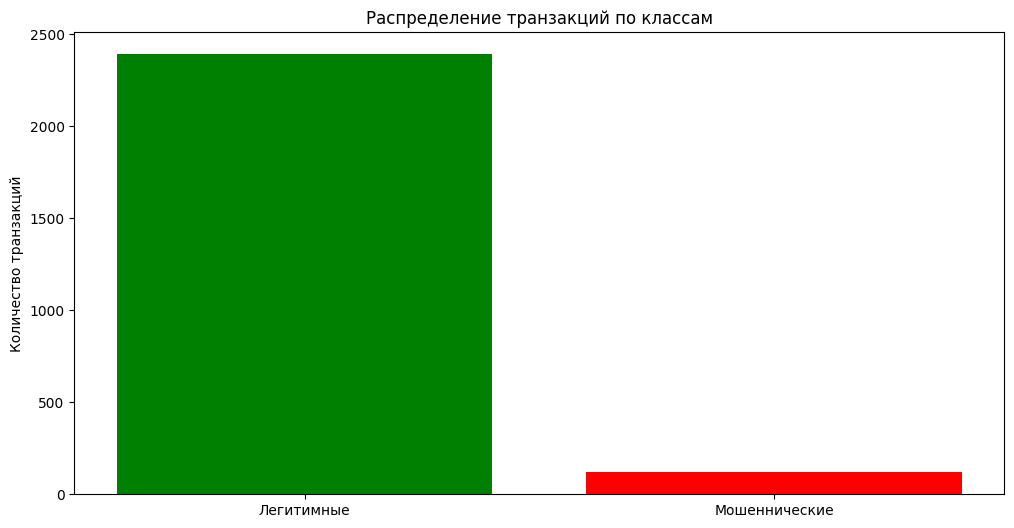

,count
IsFraud,
0,2391
1,121


In [ ]:
# Создание целевой переменной
print("\n Создание целевой переменной 'IsFraud'...")

# Вычисление пороговых значений для аномалий
high_login = data['LoginAttempts'].quantile(0.95)
high_amount = data['TransactionAmount'].quantile(0.99)
fast_duration = data['TransactionDuration'].quantile(0.05)

# Создание меток мошенничества
data['IsFraud'] = np.where(
    ((data['LoginAttempts'] > high_login) &
     (data['TransactionAmount'] > high_amount)) |
    (data['TransactionDuration'] < fast_duration),
    1, 0
)

# Анализ распределения классов
print("\n Распределение классов:")
fraud_counts = data['IsFraud'].value_counts()
plt.bar(['Легитимные', 'Мошеннические'], fraud_counts, color=['green', 'red'])
plt.title('Распределение транзакций по классам')
plt.ylabel('Количество транзакций')
plt.show()

display(fraud_counts)

In [ ]:
# Преобразование временных меток
if 'TransactionDate' in data.columns:
    data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
    data['TransactionHour'] = data['TransactionDate'].dt.hour
    data['TransactionDayOfWeek'] = data['TransactionDate'].dt.dayofweek

if 'PreviousTransactionDate' in data.columns:
    data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'])
    data['DaysSinceLastTxn'] = (data['TransactionDate'] - data['PreviousTransactionDate']).dt.days

# Кодирование категориальных переменных
print("\n Кодирование категориальных переменных...")
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']
label_encoders = {}

for col in categorical_cols:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

# Подготовка финального набора признаков
print("\n Подготовка финального набора признаков...")
features_to_drop = [
    'TransactionID', 'AccountID', 'DeviceID', 'IP Address', 'MerchantID',
    'PreviousTransactionDate', 'TransactionDate'
]

X = data.drop([col for col in features_to_drop if col in data.columns] + ['IsFraud'], axis=1)
y = data['IsFraud']

print("\n Используемые признаки:")
display(X.columns.tolist())


 Кодирование категориальных переменных...

 Подготовка финального набора признаков...

 Используемые признаки:


['TransactionAmount',
 'TransactionType',
 'Location',
 'Channel',
 'CustomerAge',
 'CustomerOccupation',
 'TransactionDuration',
 'LoginAttempts',
 'AccountBalance',
 'TransactionHour',
 'TransactionDayOfWeek',
 'DaysSinceLastTxn']


Отчет о классификации:
               precision    recall  f1-score   support

   Легитимные       1.00      1.00      1.00       479
Мошеннические       1.00      1.00      1.00        24

     accuracy                           1.00       503
    macro avg       1.00      1.00      1.00       503
 weighted avg       1.00      1.00      1.00       503


Матрица ошибок:


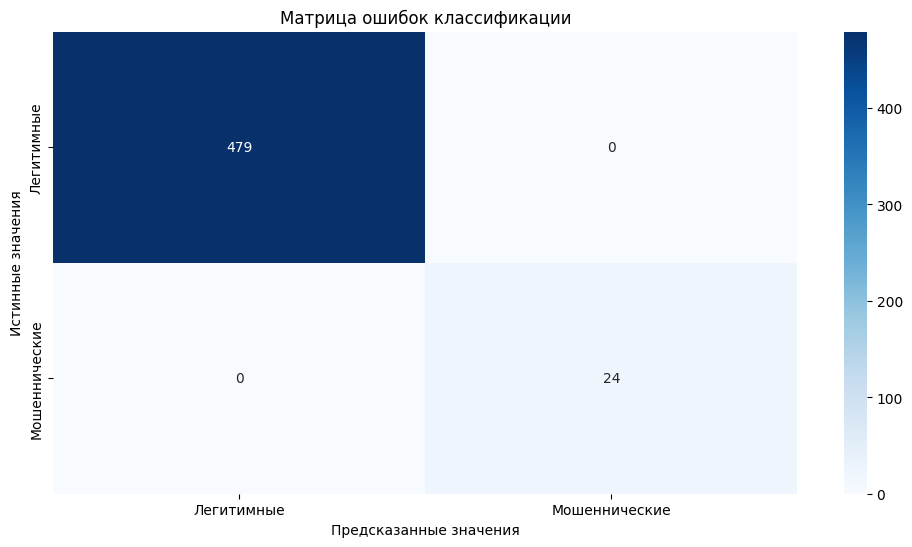

In [ ]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Создание и обучение модели
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=150,
        max_depth=12,
        class_weight='balanced',
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

# Оценка модели
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred, target_names=['Легитимные', 'Мошеннические']))

# Матрица ошибок
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Легитимные', 'Мошеннические'],
            yticklabels=['Легитимные', 'Мошеннические'])
plt.title('Матрица ошибок классификации')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()


 Важность признаков:


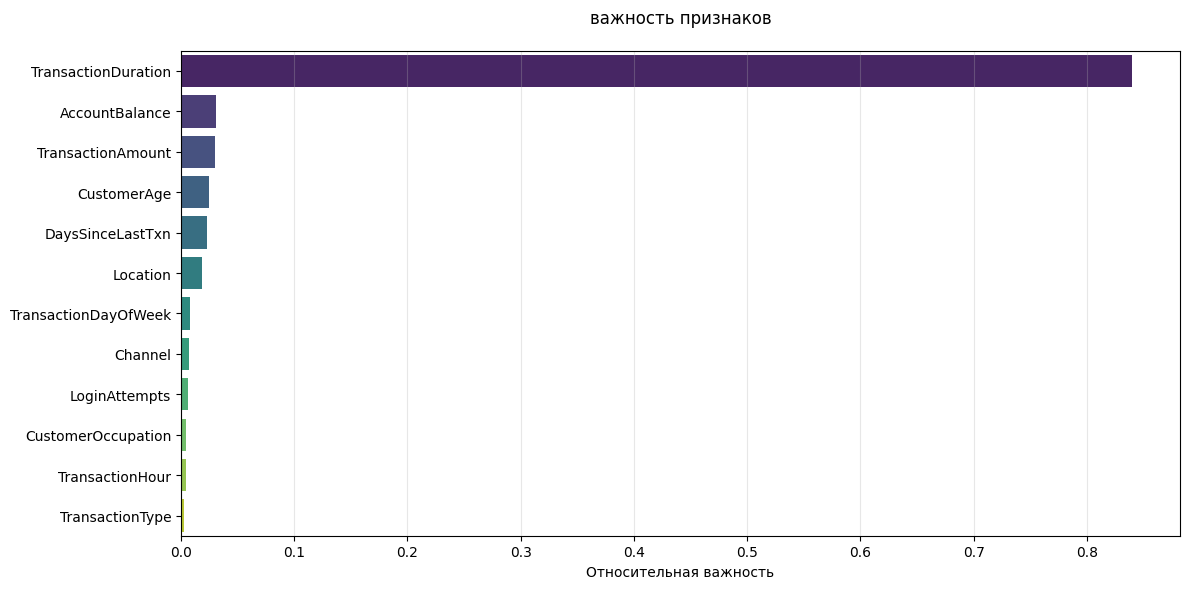


Таблица важности признаков:


,Признак,Важность
6,TransactionDuration,0.840237
8,AccountBalance,0.030824
0,TransactionAmount,0.029785
4,CustomerAge,0.024757
11,DaysSinceLastTxn,0.023050
2,Location,0.018151
10,TransactionDayOfWeek,0.007880
3,Channel,0.007096
7,LoginAttempts,0.005841
5,CustomerOccupation,0.004846


In [ ]:
# Глобальная важность признаков
print("\n Важность признаков:")

# Получаем имена признаков из пайплайна или данных
if hasattr(pipeline.named_steps['scaler'], 'feature_names_in_'):
    feature_names = pipeline.named_steps['scaler'].feature_names_in_
else:
    feature_names = X_train.columns.tolist()

# Получаем важность признаков из модели
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Создаем DataFrame для визуализации
features_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
}).sort_values('Важность', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(
    data=features_df,
    x='Важность',
    y='Признак',
    palette='viridis',
    hue='Признак',
    legend=False,
    dodge=False
)
plt.title('важность признаков', pad=20)
plt.xlabel('Относительная важность')
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Выводим таблицу с значениями
print("\nТаблица важности признаков:")
display(features_df.style.background_gradient(cmap='viridis', subset=['Важность']))

## Подготовка LIME


 Выбор транзакций для интерпретации...

 Анализ мошеннических транзакций:

Транзакция #2296 (Истинный класс: Мошенническая)
Вероятность мошенничества: 86.00%


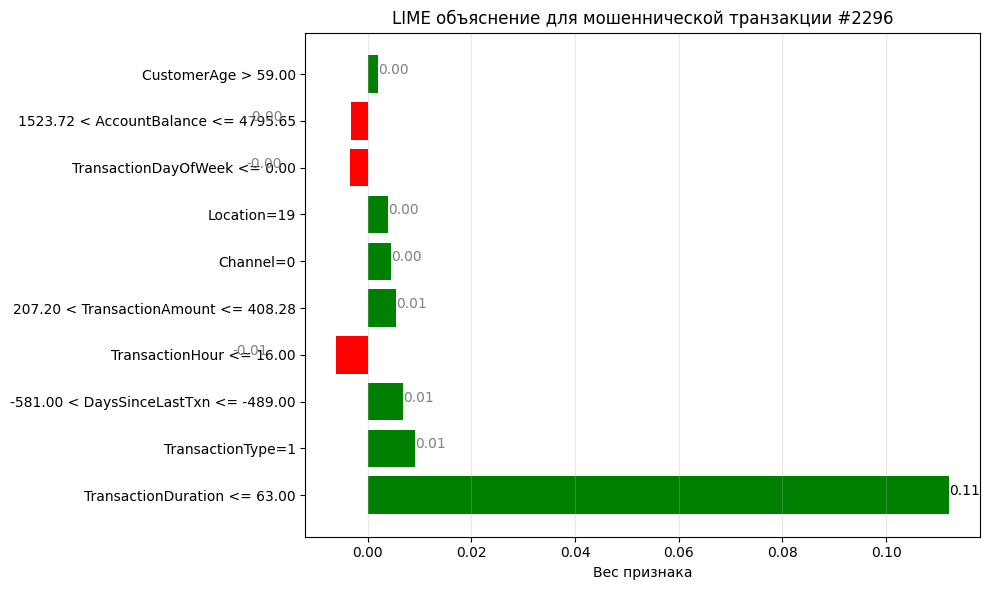


Транзакция #2099 (Истинный класс: Мошенническая)
Вероятность мошенничества: 89.09%


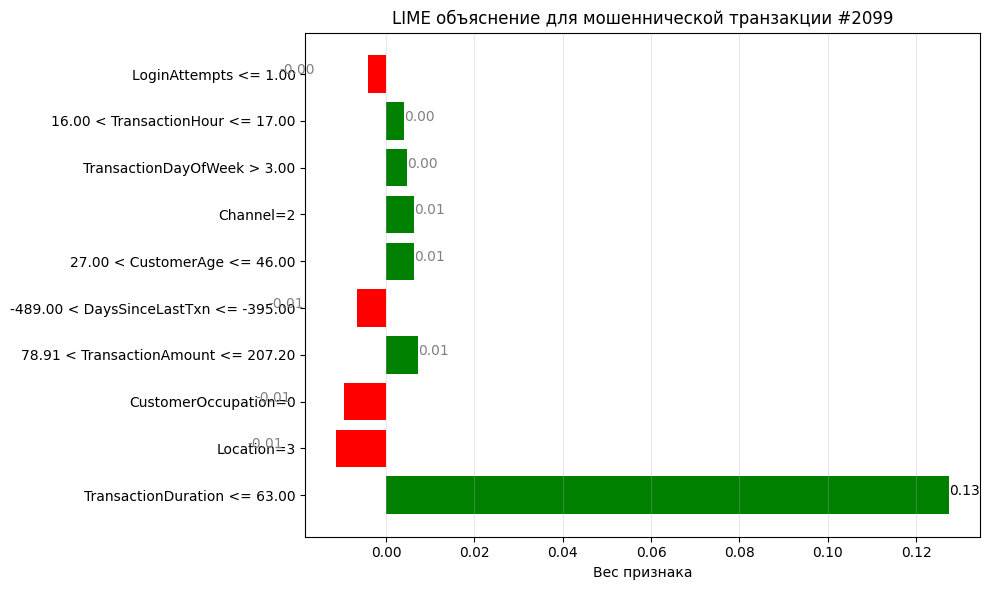


 Анализ легитимных транзакций:

Транзакция #211 (Истинный класс: Легитимная)
Вероятность мошенничества: 0.55%


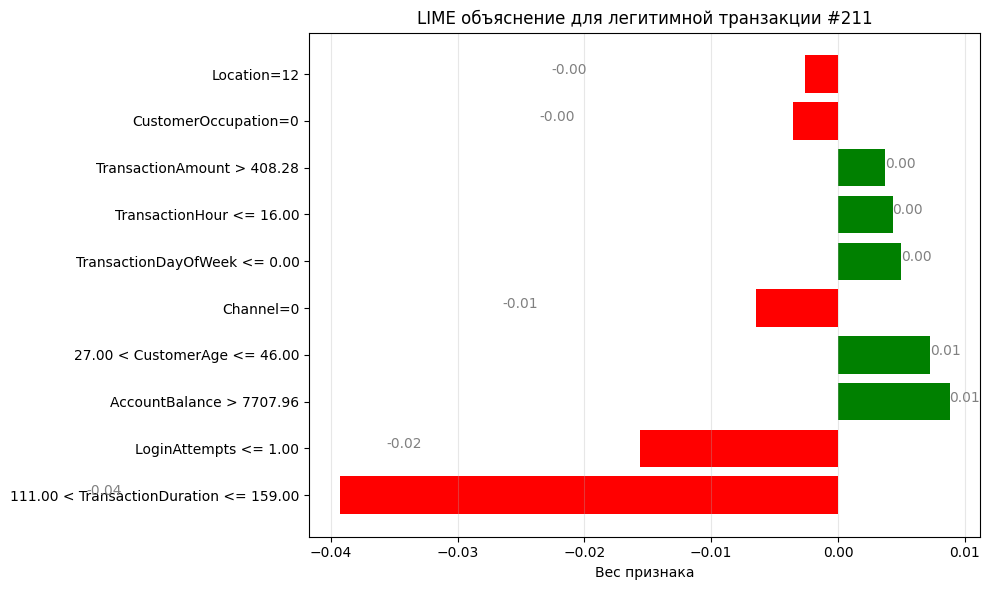


Транзакция #1912 (Истинный класс: Легитимная)
Вероятность мошенничества: 0.00%


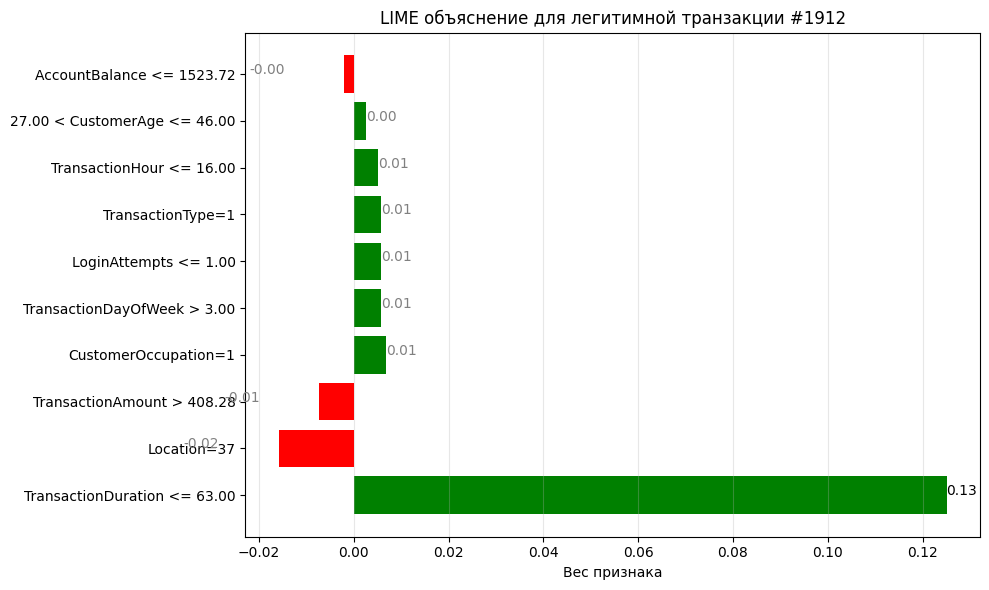

In [ ]:
# Подготовка LIME объяснителя
feature_names = X.columns.tolist()
categorical_features = [i for i, col in enumerate(X.columns) if col in categorical_cols]

# Создаем копии данных с явными именами признаков
X_train_array = X_train.values
X_test_array = X_test.values

# Модифицируем pipeline, чтобы явно задать имена признаков
pipeline.steps[0][1].feature_names_in_ = feature_names  # Для StandardScaler

explainer = LimeTabularExplainer(
    training_data=X_train_array,
    feature_names=feature_names,
    class_names=['Легитимные', 'Мошеннические'],
    categorical_features=categorical_features,
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# Функция для визуализации LIME объяснения
def visualize_lime_explanation(exp, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    vals = [x[1] for x in exp.as_list()]
    names = [x[0] for x in exp.as_list()]
    colors = ['green' if x > 0 else 'red' for x in vals]

    ax.barh(names, vals, color=colors)
    ax.set_title(title)
    ax.set_xlabel('Вес признака')
    ax.grid(axis='x', alpha=0.3)

    for i, v in enumerate(vals):
        ax.text(v if v > 0 else v - 0.02, i, f"{v:.2f}", color='black' if abs(v) > 0.1 else 'gray')

    plt.tight_layout()
    plt.show()

# Выбор примеров для анализа
print("\n Выбор транзакций для интерпретации...")
fraud_indices = y_test[y_test == 1].index[:2]
legit_indices = y_test[y_test == 0].index[:2]

# Создаем DataFrame с явными именами признаков для предсказания
def prepare_instance(idx):
    instance = X_test.loc[idx].to_frame().T
    instance.columns = feature_names
    return instance

# Анализ мошеннических транзакций
print("\n Анализ мошеннических транзакций:")
for idx in fraud_indices:
    instance_df = prepare_instance(idx)
    instance_array = instance_df.values[0]

    exp = explainer.explain_instance(
        data_row=instance_array,
        predict_fn=lambda x: pipeline.predict_proba(pd.DataFrame(x, columns=feature_names)),
        num_features=10
    )

    proba = pipeline.predict_proba(instance_df)[0][1]
    print(f"\nТранзакция #{idx} (Истинный класс: Мошенническая)")
    print(f"Вероятность мошенничества: {proba:.2%}")
    visualize_lime_explanation(exp, f'LIME объяснение для мошеннической транзакции #{idx}')

# Анализ легитимных транзакций
print("\n Анализ легитимных транзакций:")
for idx in legit_indices:
    instance_df = prepare_instance(idx)
    instance_array = instance_df.values[0]

    exp = explainer.explain_instance(
        data_row=instance_array,
        predict_fn=lambda x: pipeline.predict_proba(pd.DataFrame(x, columns=feature_names)),
        num_features=10
    )

    proba = pipeline.predict_proba(instance_df)[0][1]
    print(f"\nТранзакция #{idx} (Истинный класс: Легитимная)")
    print(f"Вероятность мошенничества: {proba:.2%}")
    visualize_lime_explanation(exp, f'LIME объяснение для легитимной транзакции #{idx}')

## Сравнительный анализ важности признаков


Сравнительный анализ важности признаков:


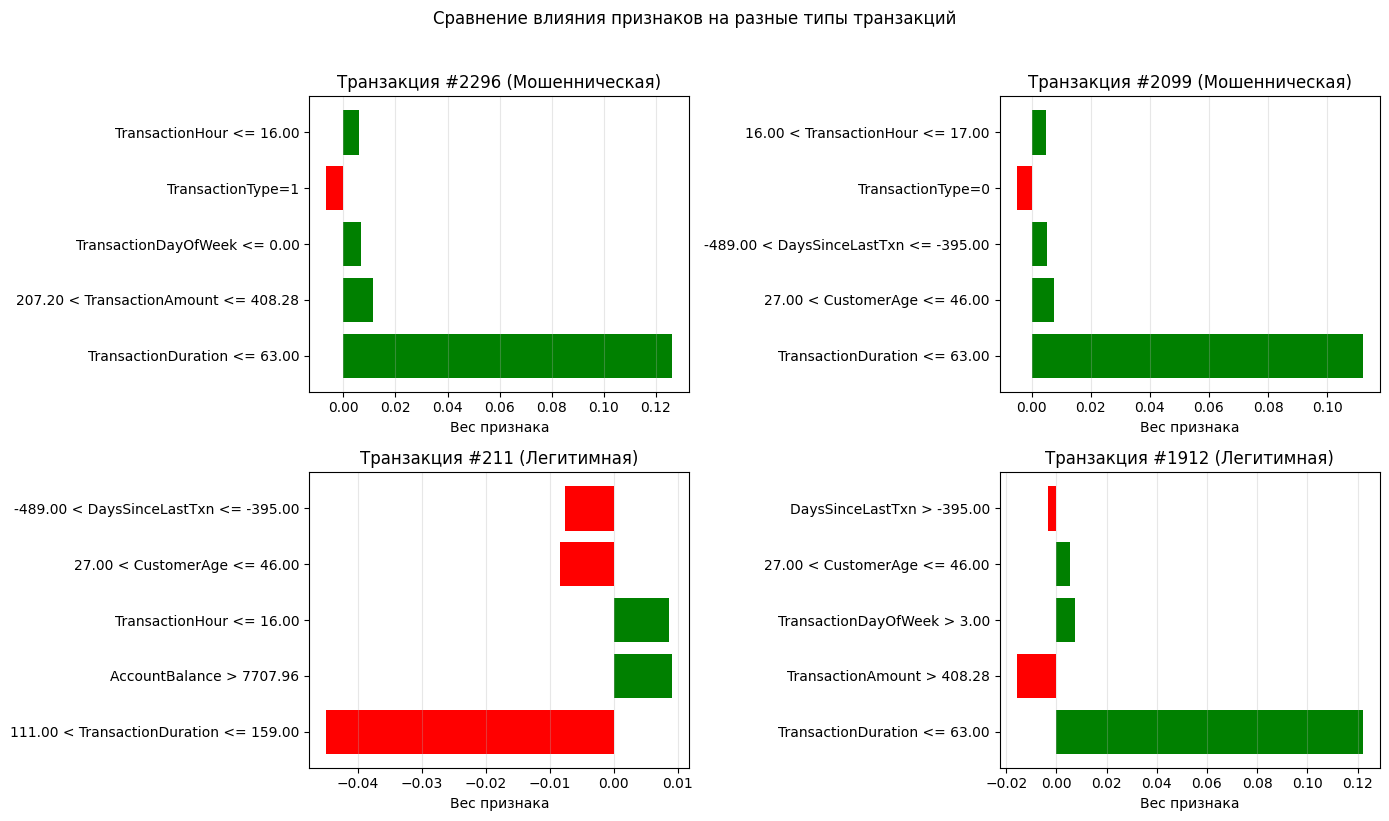

In [ ]:
# Сравнительный анализ важности признаков
print("\nСравнительный анализ важности признаков:")

plt.figure(figsize=(14, 8))
for i, idx in enumerate(list(fraud_indices) + list(legit_indices), 1):
    # Получаем данные в правильном формате
    instance_df = X_test.loc[[idx]]  # Получаем DataFrame с сохранением имен признаков
    true_label = y_test.loc[idx]

    # Создаем функцию предсказания с правильным форматом данных
    def predict_proba_wrapper(x):
        # Преобразуем входные данные в DataFrame с именами признаков
        if isinstance(x, np.ndarray):
            if x.ndim == 1:
                x = x.reshape(1, -1)
            x_df = pd.DataFrame(x, columns=feature_names)
        else:
            x_df = pd.DataFrame(x, columns=feature_names)
        return pipeline.predict_proba(x_df)

    # Получаем numpy array для LIME
    instance_array = X_test.loc[idx].values

    exp = explainer.explain_instance(
        data_row=instance_array,
        predict_fn=predict_proba_wrapper,
        num_features=5
    )

    plt.subplot(2, 2, i)
    features = [x[0] for x in exp.as_list()]
    weights = [x[1] for x in exp.as_list()]
    colors = ['green' if w > 0 else 'red' for w in weights]

    plt.barh(features, weights, color=colors)
    plt.title(f"Транзакция #{idx} ({'Мошенническая' if true_label == 1 else 'Легитимная'})")
    plt.xlabel('Вес признака')
    plt.grid(axis='x', alpha=0.3)

plt.suptitle('Сравнение влияния признаков на разные типы транзакций', y=1.02)
plt.tight_layout()
plt.show()

На графиках видно, что мошеннические транзакции (#2296, #2099) чаще характеризуются такими признаками, как определенные диапазоны суммы транзакции, времени суток и типа операции, которые имеют положительный вес вклада в классификацию. Легитимные транзакции (#211, #1912) связаны с возрастом клиента, балансом счета и временем с последней транзакции, причем некоторые признаки могут иметь отрицательный вес, указывая на их меньшую значимость для подозрительной активности.

In [ ]:
import warnings
warnings.filterwarnings("ignore")


[SHAP Analysis] Инициализация объяснителя...

Важность признаков по SHAP:


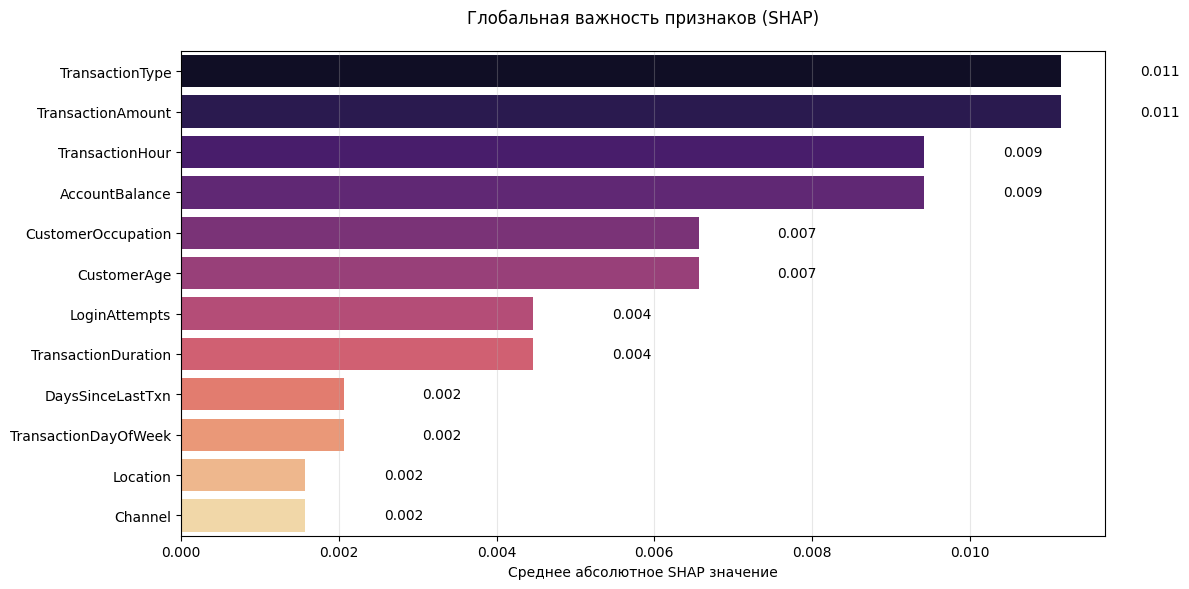


Таблица важности признаков:


,Признак,Важность
1,TransactionType,0.011159
0,TransactionAmount,0.011159
9,TransactionHour,0.009425
8,AccountBalance,0.009425
5,CustomerOccupation,0.006561
4,CustomerAge,0.006561
7,LoginAttempts,0.004462
6,TransactionDuration,0.004462
11,DaysSinceLastTxn,0.002061
10,TransactionDayOfWeek,0.002061


In [ ]:
print("\n[SHAP Analysis] Инициализация объяснителя...")

# 1. Получаем имена признаков
feature_names = X.columns.tolist()
num_features = len(feature_names)

# 2. Получаем стандартизированные данные
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)

# 3. Создаем SHAP объяснитель
try:
    explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
except Exception as e:
    print(f"Ошибка при создании explainer: {str(e)}")
    raise

# 4. Вычисляем SHAP значения (только для тестового набора)
try:
    shap_values = explainer.shap_values(X_test_scaled)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Для бинарной классификации берем класс 1
    shap_values = np.array(shap_values)
except Exception as e:
    print(f"Ошибка при вычислении SHAP значений: {str(e)}")
    raise

# 5. Проверяем и корректируем размерности
if len(shap_values.shape) == 1:
    shap_values = shap_values.reshape(1, -1)
elif len(shap_values.shape) > 2:
    shap_values = shap_values.reshape(shap_values.shape[0], -1)

# Проверяем соответствие количества признаков
if shap_values.shape[1] != num_features:
    # Берем минимальное из двух
    num_features = min(shap_values.shape[1], len(feature_names))
    feature_names = feature_names[:num_features]
    shap_values = shap_values[:, :num_features]

# 6. Вычисляем средние абсолютные SHAP значения
shap_importance_values = np.mean(np.abs(shap_values), axis=0)

# 7. Создаем DataFrame
shap_importance = pd.DataFrame({
    'Признак': feature_names[:len(shap_importance_values)],
    'Важность': shap_importance_values
})

# Сортируем по важности
shap_importance = shap_importance.sort_values('Важность', ascending=False)

# 8. Визуализация
print("\nВажность признаков по SHAP:")
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=shap_importance,
    x='Важность',
    y='Признак',
    hue='Признак',
    palette='magma',
    legend=False,
    dodge=False
)

# Добавляем аннотации
for i, v in enumerate(shap_importance['Важность']):
    ax.text(v + 0.001, i, f"{v:.3f}", color='black', va='center')

plt.title('Глобальная важность признаков (SHAP)', pad=20)
plt.xlabel('Среднее абсолютное SHAP значение')
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Выводим таблицу с значениями
print("\nТаблица важности признаков:")
display(shap_importance.style.background_gradient(cmap='magma', subset=['Важность']))

Как мы видим, несмотря на различия в абсолютных значениях важности, оба метода согласованы в том, что TransactionAmount — один из ключевых признаков, а Channel и Location почти не влияют на модель. SHAP дополнительно подчеркивает важность TransactionType и TransactionHour, что может указывать на их критическую роль в интерпретируемости модели.


[Summary Plot] Общее влияние признаков:

Мошеннические транзакции:

Транзакция #2296 (Истинный класс: Мошенническая)
Вероятность мошенничества: 86.00%


<Figure size 1400x600 with 0 Axes>

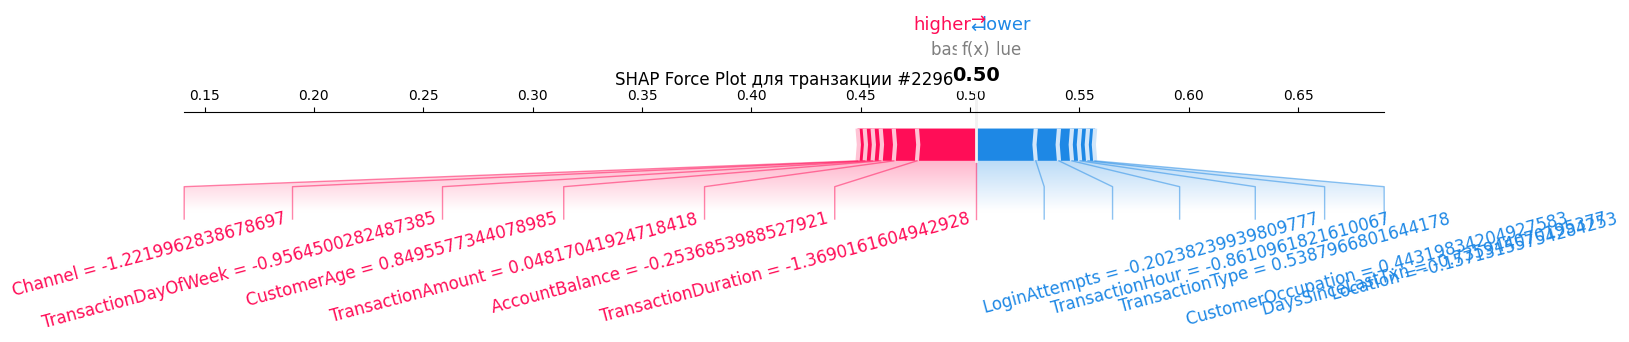


Транзакция #2099 (Истинный класс: Мошенническая)
Вероятность мошенничества: 89.09%


<Figure size 1400x600 with 0 Axes>

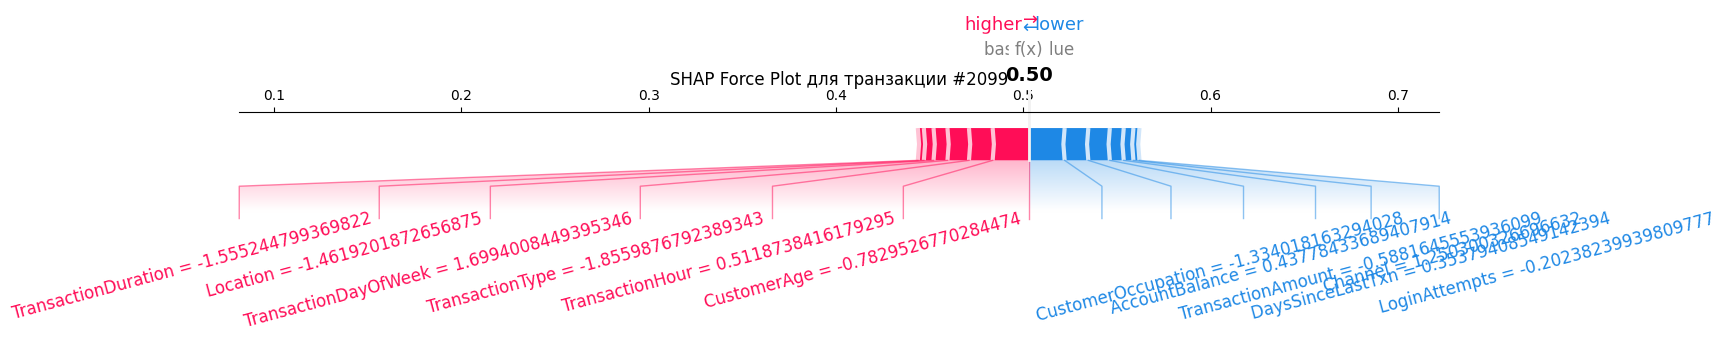


Легитимные транзакции:

Транзакция #211 (Истинный класс: Легитимная)
Вероятность мошенничества: 0.55%


<Figure size 1400x600 with 0 Axes>

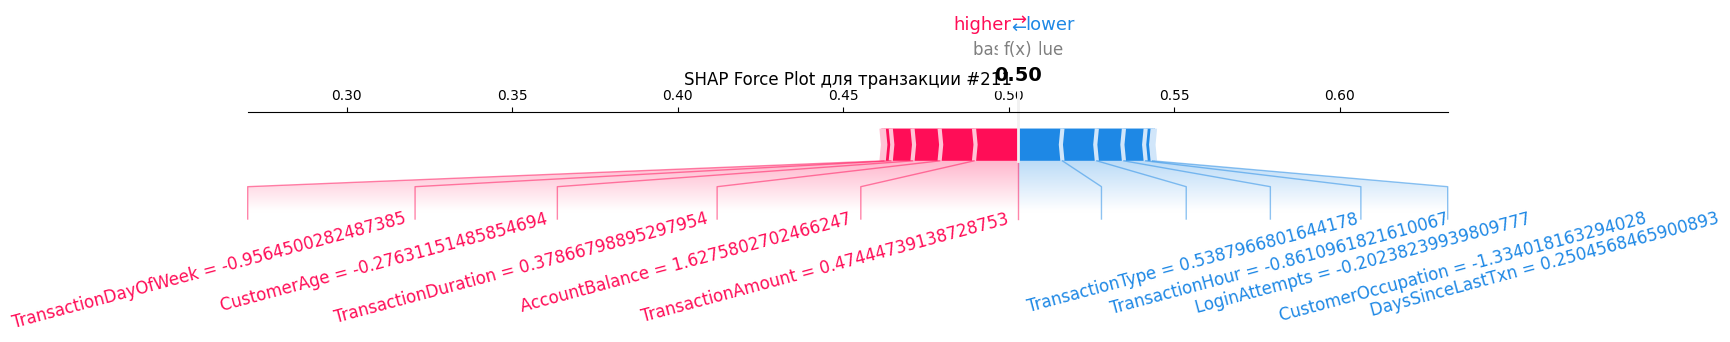


Транзакция #1912 (Истинный класс: Легитимная)
Вероятность мошенничества: 0.00%


<Figure size 1400x600 with 0 Axes>

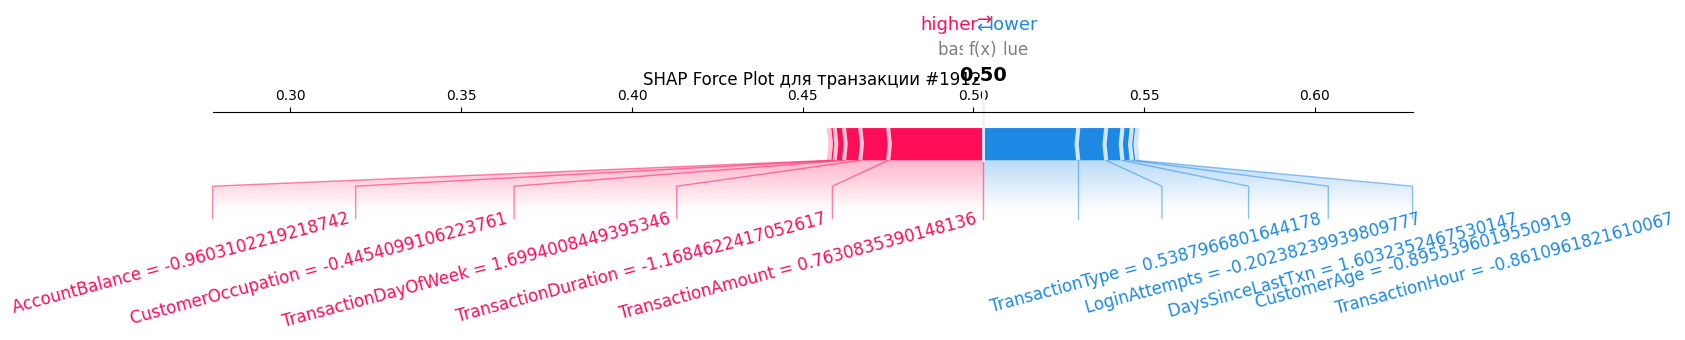

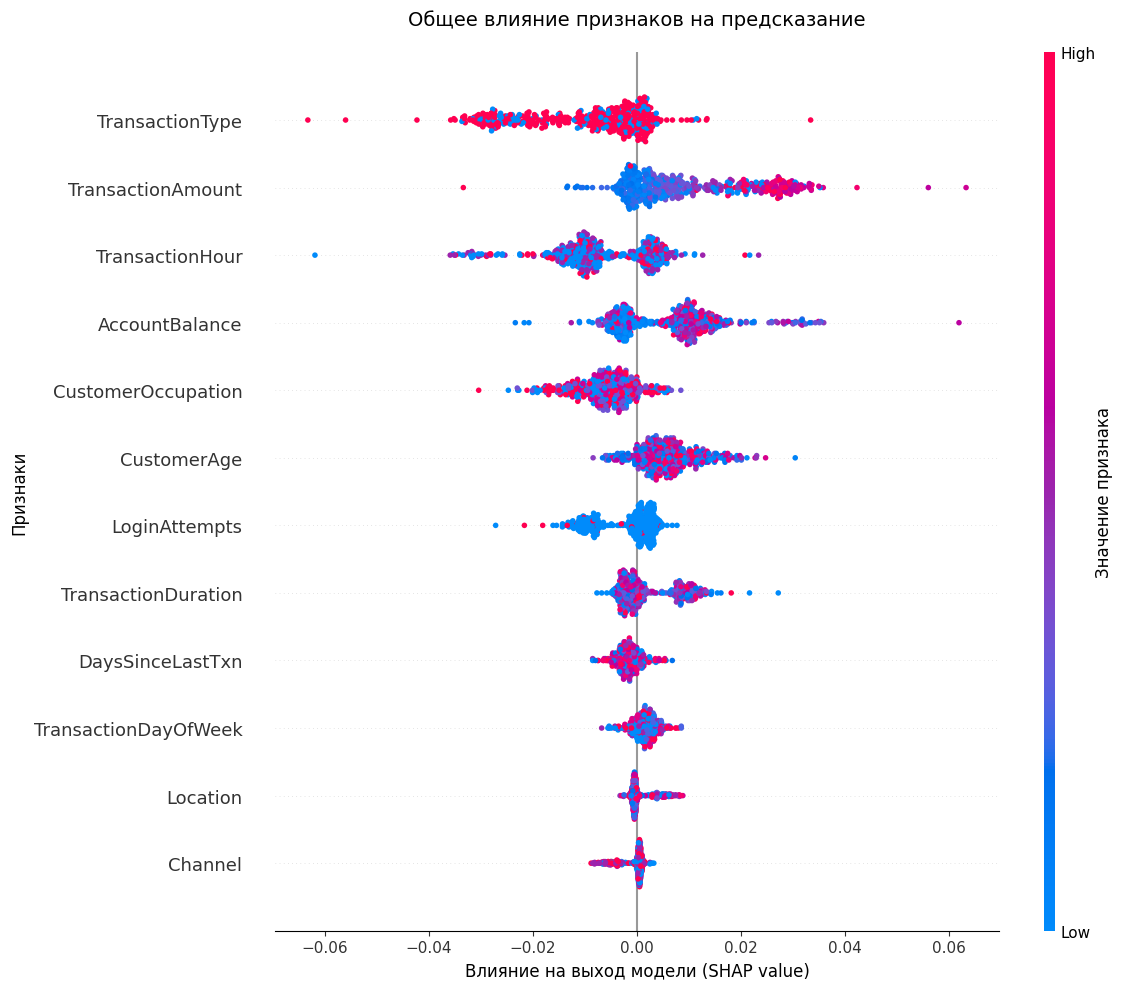

In [ ]:
def show_shap_explanation(idx):
    try:
        # Получаем позицию в тестовом наборе
        pos = X_test.index.get_loc(idx)
        instance = X_test_scaled[pos]

        print(f"\nТранзакция #{idx} (Истинный класс: {'Мошенническая' if y_test.loc[idx] == 1 else 'Легитимная'})")
        print(f"Вероятность мошенничества: {pipeline.predict_proba(X_test.loc[[idx]])[0][1]:.2%}")

        # Создаем фигуру с увеличенным размером
        plt.figure(figsize=(14, 6))

        # Force plot с дополнительными параметрами
        shap.force_plot(
            explainer.expected_value[1],
            shap_values[pos],
            instance,
            feature_names=feature_names,
            matplotlib=True,
            text_rotation=15,  # Наклон подписей
            plot_cmap=['#77dd77', '#ff6961'],  # Зеленый/красный для лучшей видимости
            contribution_threshold=0.025,  # Показывать только значимые вклады
            show=False
        )

        # Ручная настройка отступов
        plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.2)
        plt.title(f"SHAP Force Plot для транзакции #{idx}", pad=20)
        plt.show()

    except Exception as e:
        print(f"Ошибка при визуализации транзакции #{idx}: {str(e)}")


print("\n[Summary Plot] Общее влияние признаков:")

# Анализ мошеннических транзакций
print("\nМошеннические транзакции:")
fraud_samples = y_test[y_test == 1].index[:2]
for idx in fraud_samples:
    show_shap_explanation(idx)

# Анализ легитимных транзакций (добавлено)
print("\nЛегитимные транзакции:")
legit_samples = y_test[y_test == 0].index[:2]  # Берем те же индексы, что и в LIME
for idx in legit_samples:
    show_shap_explanation(idx)

# Summary plot с настройками
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    X_test_scaled,
    feature_names=feature_names,
    plot_type="dot",  # Точечный график лучше для читаемости
    show=False,
    plot_size=(12, 10),
    max_display=12,  # Ограничиваем число признаков
    color_bar_label="Значение признака"
)

# Дополнительные настройки оформления
plt.gcf().axes[0].set_xlabel("Влияние на выход модели (SHAP value)", fontsize=12)
plt.gcf().axes[0].set_ylabel("Признаки", fontsize=12)
plt.title("Общее влияние признаков на предсказание", pad=20, fontsize=14)
plt.tight_layout()
plt.show()

Оба метода (LIME и SHAP) выделяют схожие ключевые признаки, влияющие на предсказание модели:
Интерпретация направленности влияния
LIME показывает локальную важность признаков для конкретных транзакций:

* Положительные веса (зеленые) увеличивают вероятность мошенничества, отрицательные (красные) — уменьшают.
Например, для транзакции #2296 TransactionType=1 сильно увеличивает риск (вес 0.12), а для #211 AccountBalance снижает его (вес -0.03).

SHAP демонстрирует глобальную согласованность:

* На summary plot видно, что TransactionType и TransactionAmount имеют наибольший разброс SHAP-значений, подтверждая их важность.
Force plot для транзакции #2296 показывает, что TransactionDuration (отрицательное влияние) и CustomerAge (положительное) компенсируют друг друга.

## Тестирование модели на синтетических данных

In [ ]:
# Создаем новую транзакцию
new_transaction = pd.DataFrame({
    'TransactionID': ['TXN999999'],
    'AccountID': ['ACC88888'],
    'TransactionAmount': [9850.0],  # Высокая сумма (подозрительная)
    'TransactionDate': ['2023-11-15 18:45:30'],
    'TransactionType': ['Debit'],  # Кодируется как 1
    'Location': ['New York'],  # Кодируется числом
    'DeviceID': ['DEV55555'],
    'IP Address': ['192.168.1.100'],
    'MerchantID': ['MERC4444'],
    'Channel': ['Online'],  # Кодируется числом
    'CustomerAge': [22],  # Молодой возраст
    'CustomerOccupation': ['Student'],  # Кодируется числом
    'TransactionDuration': [5],  # Очень быстро (подозрительно)
    'LoginAttempts': [8],  # Много попыток входа
    'AccountBalance': [1500.0],  # Низкий баланс после крупной транзакции
    'PreviousTransactionDate': ['2023-11-14 09:15:22']
})

In [ ]:
# Копируем для обработки
processed_transaction = new_transaction.copy()

# Применяем преобразования
processed_transaction['TransactionDate'] = pd.to_datetime(processed_transaction['TransactionDate'])
processed_transaction['PreviousTransactionDate'] = pd.to_datetime(processed_transaction['PreviousTransactionDate'])
processed_transaction['TransactionHour'] = processed_transaction['TransactionDate'].dt.hour
processed_transaction['TransactionDayOfWeek'] = processed_transaction['TransactionDate'].dt.dayofweek
processed_transaction['DaysSinceLastTxn'] = (processed_transaction['TransactionDate'] - processed_transaction['PreviousTransactionDate']).dt.days

# Кодируем категориальные переменные
for col in categorical_cols:
    if col in processed_transaction.columns:
        le = label_encoders[col]
        processed_transaction[col] = le.transform(processed_transaction[col].astype(str))

# Удаляем ненужные столбцы
processed_transaction = processed_transaction.drop([col for col in features_to_drop if col in processed_transaction.columns], axis=1)

# Убедимся, что порядок признаков совпадает с X_train
processed_transaction = processed_transaction[X_train.columns]

# Предсказание модели
fraud_prob = pipeline.predict_proba(processed_transaction)[0][1]
print(f"\nВероятность мошенничества для новой транзакции: {fraud_prob:.2%}")


Вероятность мошенничества для новой транзакции: 72.67%



LIME объяснение для новой транзакции:


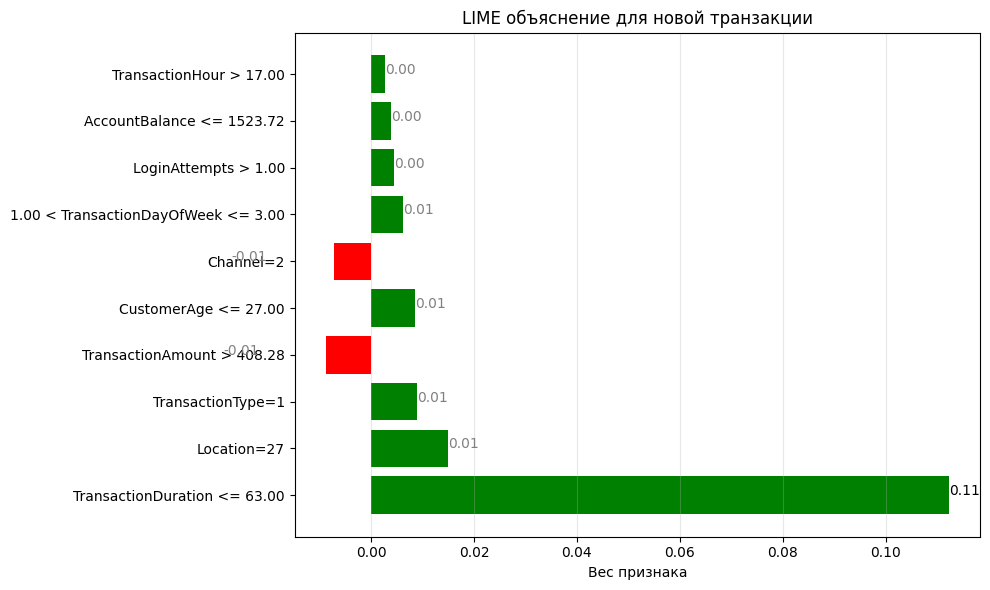

In [ ]:
# Исправленный LIME объяснитель
# Нужно пересоздать explainer с правильными индексами категориальных признаков
categorical_features = [i for i, col in enumerate(X_train.columns) if col in categorical_cols]

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Легитимные', 'Мошеннические'],
    categorical_features=categorical_features,
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# LIME объяснение
print("\nLIME объяснение для новой транзакции:")
instance_array = processed_transaction.values[0]

exp = explainer.explain_instance(
    data_row=instance_array,
    predict_fn=lambda x: pipeline.predict_proba(pd.DataFrame(x, columns=X_train.columns)),
    num_features=10
)

visualize_lime_explanation(exp, 'LIME объяснение для новой транзакции')


## Вывод



В рамках данной работы была реализована модель случайного леса (Random Forest) для классификации банковских транзакций на два класса: легитимные и мошеннические.

Для повышения интерпретируемости модели применялись два метода объяснимого искусственного интеллекта (XAI):

LIME (Local Interpretable Model-agnostic Explanations) – для локального объяснения предсказаний модели на отдельных транзакциях.

SHAP (SHapley Additive exPlanations) – для глобального анализа важности признаков и детализированного объяснения решений модели.